In [1]:
import os  
import numpy as np
from scipy import *
from numpy import dot, multiply, diag, power, pi, exp, sin, cos, cosh, tanh, real, imag
from numpy.linalg import inv, eig, pinv,norm
from scipy.linalg import svd, svdvals 
import scipy.io as sio  
import re  
import warnings
warnings.filterwarnings("ignore")

import torch 
from torch.autograd import Variable
from torch.optim import Adam, SGD   
import torch.optim as optim
import matplotlib.pyplot as plt 

from utility import *
from model import *

In [2]:
# tunable parameters
gamma = 0.02 
lam  = 0.1  
# parameters
savename = 'Trade_regu_test'  
n_class =87
dim_input = 1
# parameters for CNN 
patience = 30  
gamma = 0.02 
batch_size =70
display_step = 100  
num_bus =68 
learning_rate = 0.01               
rootPath =  './data'
trainName = 'train_data.mat'  
testName = 'testing_sigPQ_perturb_1' 
scenario = 1 # choose 1 or 2 denoting the two kinds of testing data in the corresponding scenario 
model_dir  = './saved_model' 
epsilon = 0.01
k = 7
alpha = 0.01 
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
weight_decay = 5e-5
epochs =1000  
dim_input = 1 
dim_hidden = [4,8,8,8]
nclass = 87
seed = 1 
early_stop = False


In [3]:
# load data
data = sio.loadmat(os.path.join(rootPath, trainName))
linedata, Y,  line_neib = loadline(rootPath  ) 
Y_ri = np.r_[np.c_[Y.real, -Y.imag], np.c_[ Y.imag, Y.real ]].T 
w = choose_w(linedata,2)  
train_x,    train_labels, train_num  = load_all_data_VI(w,rootPath, trainName ) 
up_limit = np.r_[np.ones((num_bus*4, 1))*epsilon ]
down_limit = np.r_[-np.ones((num_bus*4, 1))*epsilon ]
 

In [4]:
def main(seed, dim_input, dim_hidden):
    np.random.seed( seed)
    torch.manual_seed( seed) 
    
    model = Net(dim_input, dim_hidden, nclass) 
    model.apply(weights_init) 
    model.train()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    criterion = CrossEntropyLoss()   
    pre_robust_acc = 0. 
    x_train, y_train = Variable(train_x)  , Variable(train_labels) 
    train_best = float('Inf') 
    train_loss_list= []
    for epoch in range( epochs):  
        train_acc = 0
        train_n = 0 
        train_loss = 0 
        for i in range(int(train_x.shape[0] / batch_size)):
            id_train = np.random.choice(train_x.shape[0], batch_size, replace= False) 
            optimizer.zero_grad() 
            loss, output  = trades_loss(  model=model,
                               x_natural=x_train[id_train],
                               y=y_train[id_train],
                                        Y_ri = Y_ri, 
                               optimizer=optimizer,
                               up_limit = up_limit,
                               down_limit = down_limit,
                               step_size= alpha, 
                               perturb_steps= k,
                                        gamma = gamma,
                               lam= lam)   
            loss.backward()
            optimizer.step() 
            train_loss_list.append(loss.item())   
            train_acc  = (output.max(1)[1] == y_train[id_train]).sum().item() *100/np.shape(id_train)[0]  
            train_n += y_train[id_train].size(0)
            if epoch%5 == 0: 
                print('Training Epoch: {}, [{}/{}, {:.0f}%], loss is {:.6f}'\
                      .format(epoch  , i * batch_size, train_x.shape[0],\
                              train_acc  , loss.item()  )) 
                if train_loss < train_best:
                    print('best model')
                    print('Epoch', epoch)
                    train_best += loss.item()
                    torch.save(model.state_dict(), os.path.join(model_dir,  'model-' + savename + '.pt'))
                    torch.save(optimizer.state_dict(), os.path.join(model_dir, 'opt-' + savename + '.tar'))
            train_loss_list.append(loss.item())  
        if not early_stop:
            best_state_dict = model.state_dict()  
    plt.plot(train_loss_list)
    return train_loss_list , train_best 
 

Training Epoch: 0, [0/560, 0%], loss is 4.604379
best model
Epoch 0
Training Epoch: 0, [70/560, 3%], loss is 4.493090
best model
Epoch 0
Training Epoch: 0, [140/560, 7%], loss is 4.434260
best model
Epoch 0
Training Epoch: 0, [210/560, 3%], loss is 4.296442
best model
Epoch 0
Training Epoch: 0, [280/560, 0%], loss is 4.267248
best model
Epoch 0
Training Epoch: 0, [350/560, 3%], loss is 4.235191
best model
Epoch 0
Training Epoch: 0, [420/560, 3%], loss is 4.060098
best model
Epoch 0
Training Epoch: 0, [490/560, 10%], loss is 3.998548
best model
Epoch 0
Training Epoch: 5, [0/560, 34%], loss is 2.419361
best model
Epoch 5
Training Epoch: 5, [70/560, 34%], loss is 2.247650
best model
Epoch 5
Training Epoch: 5, [140/560, 43%], loss is 2.205443
best model
Epoch 5
Training Epoch: 5, [210/560, 47%], loss is 2.085081
best model
Epoch 5
Training Epoch: 5, [280/560, 40%], loss is 2.262362
best model
Epoch 5
Training Epoch: 5, [350/560, 50%], loss is 1.883036
best model
Epoch 5
Training Epoch: 5, 

Training Epoch: 70, [210/560, 73%], loss is 0.308108
best model
Epoch 70
Training Epoch: 70, [280/560, 79%], loss is 0.274429
best model
Epoch 70
Training Epoch: 70, [350/560, 74%], loss is 0.323094
best model
Epoch 70
Training Epoch: 70, [420/560, 77%], loss is 0.229127
best model
Epoch 70
Training Epoch: 70, [490/560, 67%], loss is 0.291534
best model
Epoch 70
Training Epoch: 75, [0/560, 77%], loss is 0.148341
best model
Epoch 75
Training Epoch: 75, [70/560, 84%], loss is 0.168947
best model
Epoch 75
Training Epoch: 75, [140/560, 77%], loss is 0.194371
best model
Epoch 75
Training Epoch: 75, [210/560, 86%], loss is 0.128543
best model
Epoch 75
Training Epoch: 75, [280/560, 93%], loss is 0.108190
best model
Epoch 75
Training Epoch: 75, [350/560, 90%], loss is 0.169675
best model
Epoch 75
Training Epoch: 75, [420/560, 87%], loss is 0.140808
best model
Epoch 75
Training Epoch: 75, [490/560, 86%], loss is 0.173424
best model
Epoch 75
Training Epoch: 80, [0/560, 70%], loss is 0.239603
bes

Training Epoch: 140, [210/560, 84%], loss is 0.131258
best model
Epoch 140
Training Epoch: 140, [280/560, 77%], loss is 0.171515
best model
Epoch 140
Training Epoch: 140, [350/560, 89%], loss is 0.087152
best model
Epoch 140
Training Epoch: 140, [420/560, 77%], loss is 0.146612
best model
Epoch 140
Training Epoch: 140, [490/560, 76%], loss is 0.167126
best model
Epoch 140
Training Epoch: 145, [0/560, 86%], loss is 0.100878
best model
Epoch 145
Training Epoch: 145, [70/560, 80%], loss is 0.219345
best model
Epoch 145
Training Epoch: 145, [140/560, 74%], loss is 0.228432
best model
Epoch 145
Training Epoch: 145, [210/560, 81%], loss is 0.119846
best model
Epoch 145
Training Epoch: 145, [280/560, 79%], loss is 0.174426
best model
Epoch 145
Training Epoch: 145, [350/560, 79%], loss is 0.147493
best model
Epoch 145
Training Epoch: 145, [420/560, 77%], loss is 0.161042
best model
Epoch 145
Training Epoch: 145, [490/560, 79%], loss is 0.134259
best model
Epoch 145
Training Epoch: 150, [0/560,

Training Epoch: 210, [210/560, 89%], loss is 0.080762
best model
Epoch 210
Training Epoch: 210, [280/560, 93%], loss is 0.088663
best model
Epoch 210
Training Epoch: 210, [350/560, 86%], loss is 0.194292
best model
Epoch 210
Training Epoch: 210, [420/560, 84%], loss is 0.111197
best model
Epoch 210
Training Epoch: 210, [490/560, 80%], loss is 0.150507
best model
Epoch 210
Training Epoch: 215, [0/560, 80%], loss is 0.213053
best model
Epoch 215
Training Epoch: 215, [70/560, 76%], loss is 0.252349
best model
Epoch 215
Training Epoch: 215, [140/560, 76%], loss is 0.213448
best model
Epoch 215
Training Epoch: 215, [210/560, 76%], loss is 0.169936
best model
Epoch 215
Training Epoch: 215, [280/560, 79%], loss is 0.157954
best model
Epoch 215
Training Epoch: 215, [350/560, 90%], loss is 0.076431
best model
Epoch 215
Training Epoch: 215, [420/560, 79%], loss is 0.170132
best model
Epoch 215
Training Epoch: 215, [490/560, 79%], loss is 0.281439
best model
Epoch 215
Training Epoch: 220, [0/560,

Training Epoch: 280, [210/560, 90%], loss is 0.130597
best model
Epoch 280
Training Epoch: 280, [280/560, 76%], loss is 0.136068
best model
Epoch 280
Training Epoch: 280, [350/560, 70%], loss is 0.185207
best model
Epoch 280
Training Epoch: 280, [420/560, 81%], loss is 0.134761
best model
Epoch 280
Training Epoch: 280, [490/560, 83%], loss is 0.130220
best model
Epoch 280
Training Epoch: 285, [0/560, 76%], loss is 0.152594
best model
Epoch 285
Training Epoch: 285, [70/560, 80%], loss is 0.170305
best model
Epoch 285
Training Epoch: 285, [140/560, 84%], loss is 0.164081
best model
Epoch 285
Training Epoch: 285, [210/560, 77%], loss is 0.254701
best model
Epoch 285
Training Epoch: 285, [280/560, 80%], loss is 0.120622
best model
Epoch 285
Training Epoch: 285, [350/560, 74%], loss is 0.297095
best model
Epoch 285
Training Epoch: 285, [420/560, 76%], loss is 0.794040
best model
Epoch 285
Training Epoch: 285, [490/560, 81%], loss is 0.358502
best model
Epoch 285
Training Epoch: 290, [0/560,

Training Epoch: 350, [210/560, 83%], loss is 0.094695
best model
Epoch 350
Training Epoch: 350, [280/560, 89%], loss is 0.079848
best model
Epoch 350
Training Epoch: 350, [350/560, 70%], loss is 0.168029
best model
Epoch 350
Training Epoch: 350, [420/560, 81%], loss is 0.106288
best model
Epoch 350
Training Epoch: 350, [490/560, 83%], loss is 0.128300
best model
Epoch 350
Training Epoch: 355, [0/560, 94%], loss is 0.056262
best model
Epoch 355
Training Epoch: 355, [70/560, 76%], loss is 0.124436
best model
Epoch 355
Training Epoch: 355, [140/560, 76%], loss is 0.132934
best model
Epoch 355
Training Epoch: 355, [210/560, 81%], loss is 0.077233
best model
Epoch 355
Training Epoch: 355, [280/560, 87%], loss is 0.069386
best model
Epoch 355
Training Epoch: 355, [350/560, 86%], loss is 0.127695
best model
Epoch 355
Training Epoch: 355, [420/560, 87%], loss is 0.085816
best model
Epoch 355
Training Epoch: 355, [490/560, 79%], loss is 0.133716
best model
Epoch 355
Training Epoch: 360, [0/560,

Training Epoch: 420, [210/560, 76%], loss is 0.142395
best model
Epoch 420
Training Epoch: 420, [280/560, 80%], loss is 0.098365
best model
Epoch 420
Training Epoch: 420, [350/560, 93%], loss is 0.043272
best model
Epoch 420
Training Epoch: 420, [420/560, 77%], loss is 0.105637
best model
Epoch 420
Training Epoch: 420, [490/560, 83%], loss is 0.118720
best model
Epoch 420
Training Epoch: 425, [0/560, 81%], loss is 0.108639
best model
Epoch 425
Training Epoch: 425, [70/560, 89%], loss is 0.080021
best model
Epoch 425
Training Epoch: 425, [140/560, 76%], loss is 0.167116
best model
Epoch 425
Training Epoch: 425, [210/560, 71%], loss is 0.160344
best model
Epoch 425
Training Epoch: 425, [280/560, 80%], loss is 0.110270
best model
Epoch 425
Training Epoch: 425, [350/560, 79%], loss is 0.158337
best model
Epoch 425
Training Epoch: 425, [420/560, 84%], loss is 0.106159
best model
Epoch 425
Training Epoch: 425, [490/560, 89%], loss is 0.073907
best model
Epoch 425
Training Epoch: 430, [0/560,

Training Epoch: 490, [210/560, 84%], loss is 0.095509
best model
Epoch 490
Training Epoch: 490, [280/560, 89%], loss is 0.069425
best model
Epoch 490
Training Epoch: 490, [350/560, 83%], loss is 0.095237
best model
Epoch 490
Training Epoch: 490, [420/560, 89%], loss is 0.102261
best model
Epoch 490
Training Epoch: 490, [490/560, 89%], loss is 0.086321
best model
Epoch 490
Training Epoch: 495, [0/560, 84%], loss is 0.112540
best model
Epoch 495
Training Epoch: 495, [70/560, 80%], loss is 0.233626
best model
Epoch 495
Training Epoch: 495, [140/560, 80%], loss is 0.277970
best model
Epoch 495
Training Epoch: 495, [210/560, 81%], loss is 0.141429
best model
Epoch 495
Training Epoch: 495, [280/560, 80%], loss is 0.113768
best model
Epoch 495
Training Epoch: 495, [350/560, 71%], loss is 0.315827
best model
Epoch 495
Training Epoch: 495, [420/560, 77%], loss is 0.226253
best model
Epoch 495
Training Epoch: 495, [490/560, 77%], loss is 0.144305
best model
Epoch 495
Training Epoch: 500, [0/560,

Training Epoch: 560, [210/560, 91%], loss is 0.081985
best model
Epoch 560
Training Epoch: 560, [280/560, 87%], loss is 0.109526
best model
Epoch 560
Training Epoch: 560, [350/560, 81%], loss is 0.123998
best model
Epoch 560
Training Epoch: 560, [420/560, 87%], loss is 0.120995
best model
Epoch 560
Training Epoch: 560, [490/560, 83%], loss is 0.079170
best model
Epoch 560
Training Epoch: 565, [0/560, 87%], loss is 0.072760
best model
Epoch 565
Training Epoch: 565, [70/560, 79%], loss is 0.141055
best model
Epoch 565
Training Epoch: 565, [140/560, 84%], loss is 0.070475
best model
Epoch 565
Training Epoch: 565, [210/560, 89%], loss is 0.071706
best model
Epoch 565
Training Epoch: 565, [280/560, 90%], loss is 0.051550
best model
Epoch 565
Training Epoch: 565, [350/560, 89%], loss is 0.064150
best model
Epoch 565
Training Epoch: 565, [420/560, 86%], loss is 0.087848
best model
Epoch 565
Training Epoch: 565, [490/560, 89%], loss is 0.073570
best model
Epoch 565
Training Epoch: 570, [0/560,

Training Epoch: 630, [210/560, 84%], loss is 0.219976
best model
Epoch 630
Training Epoch: 630, [280/560, 86%], loss is 0.125064
best model
Epoch 630
Training Epoch: 630, [350/560, 80%], loss is 0.162991
best model
Epoch 630
Training Epoch: 630, [420/560, 84%], loss is 0.070569
best model
Epoch 630
Training Epoch: 630, [490/560, 89%], loss is 0.086717
best model
Epoch 630
Training Epoch: 635, [0/560, 90%], loss is 0.139545
best model
Epoch 635
Training Epoch: 635, [70/560, 76%], loss is 0.149853
best model
Epoch 635
Training Epoch: 635, [140/560, 89%], loss is 0.093120
best model
Epoch 635
Training Epoch: 635, [210/560, 89%], loss is 0.084210
best model
Epoch 635
Training Epoch: 635, [280/560, 86%], loss is 0.143035
best model
Epoch 635
Training Epoch: 635, [350/560, 84%], loss is 0.187367
best model
Epoch 635
Training Epoch: 635, [420/560, 81%], loss is 0.208267
best model
Epoch 635
Training Epoch: 635, [490/560, 81%], loss is 0.120263
best model
Epoch 635
Training Epoch: 640, [0/560,

Training Epoch: 700, [210/560, 84%], loss is 0.098142
best model
Epoch 700
Training Epoch: 700, [280/560, 80%], loss is 0.082551
best model
Epoch 700
Training Epoch: 700, [350/560, 83%], loss is 0.127867
best model
Epoch 700
Training Epoch: 700, [420/560, 81%], loss is 0.101252
best model
Epoch 700
Training Epoch: 700, [490/560, 90%], loss is 0.068764
best model
Epoch 700
Training Epoch: 705, [0/560, 89%], loss is 0.067702
best model
Epoch 705
Training Epoch: 705, [70/560, 91%], loss is 0.047762
best model
Epoch 705
Training Epoch: 705, [140/560, 90%], loss is 0.073820
best model
Epoch 705
Training Epoch: 705, [210/560, 90%], loss is 0.060233
best model
Epoch 705
Training Epoch: 705, [280/560, 91%], loss is 0.044858
best model
Epoch 705
Training Epoch: 705, [350/560, 81%], loss is 0.119983
best model
Epoch 705
Training Epoch: 705, [420/560, 84%], loss is 0.078007
best model
Epoch 705
Training Epoch: 705, [490/560, 86%], loss is 0.070243
best model
Epoch 705
Training Epoch: 710, [0/560,

Training Epoch: 770, [210/560, 80%], loss is 0.173775
best model
Epoch 770
Training Epoch: 770, [280/560, 83%], loss is 0.170308
best model
Epoch 770
Training Epoch: 770, [350/560, 83%], loss is 0.097100
best model
Epoch 770
Training Epoch: 770, [420/560, 79%], loss is 0.241949
best model
Epoch 770
Training Epoch: 770, [490/560, 89%], loss is 0.170755
best model
Epoch 770
Training Epoch: 775, [0/560, 87%], loss is 0.272970
best model
Epoch 775
Training Epoch: 775, [70/560, 79%], loss is 0.233446
best model
Epoch 775
Training Epoch: 775, [140/560, 77%], loss is 0.156878
best model
Epoch 775
Training Epoch: 775, [210/560, 77%], loss is 0.252814
best model
Epoch 775
Training Epoch: 775, [280/560, 89%], loss is 0.253205
best model
Epoch 775
Training Epoch: 775, [350/560, 80%], loss is 0.118073
best model
Epoch 775
Training Epoch: 775, [420/560, 83%], loss is 0.100169
best model
Epoch 775
Training Epoch: 775, [490/560, 76%], loss is 0.299076
best model
Epoch 775
Training Epoch: 780, [0/560,

Training Epoch: 840, [210/560, 79%], loss is 0.570481
best model
Epoch 840
Training Epoch: 840, [280/560, 87%], loss is 0.162726
best model
Epoch 840
Training Epoch: 840, [350/560, 97%], loss is 0.157144
best model
Epoch 840
Training Epoch: 840, [420/560, 87%], loss is 0.145011
best model
Epoch 840
Training Epoch: 840, [490/560, 86%], loss is 0.156695
best model
Epoch 840
Training Epoch: 845, [0/560, 73%], loss is 0.248888
best model
Epoch 845
Training Epoch: 845, [70/560, 84%], loss is 0.105231
best model
Epoch 845
Training Epoch: 845, [140/560, 86%], loss is 0.099084
best model
Epoch 845
Training Epoch: 845, [210/560, 84%], loss is 0.142683
best model
Epoch 845
Training Epoch: 845, [280/560, 86%], loss is 0.096343
best model
Epoch 845
Training Epoch: 845, [350/560, 90%], loss is 0.124433
best model
Epoch 845
Training Epoch: 845, [420/560, 87%], loss is 0.130938
best model
Epoch 845
Training Epoch: 845, [490/560, 74%], loss is 0.165050
best model
Epoch 845
Training Epoch: 850, [0/560,

Training Epoch: 910, [210/560, 86%], loss is 0.104689
best model
Epoch 910
Training Epoch: 910, [280/560, 87%], loss is 0.131812
best model
Epoch 910
Training Epoch: 910, [350/560, 84%], loss is 0.228577
best model
Epoch 910
Training Epoch: 910, [420/560, 86%], loss is 0.188168
best model
Epoch 910
Training Epoch: 910, [490/560, 83%], loss is 0.099781
best model
Epoch 910
Training Epoch: 915, [0/560, 84%], loss is 0.070049
best model
Epoch 915
Training Epoch: 915, [70/560, 84%], loss is 0.098125
best model
Epoch 915
Training Epoch: 915, [140/560, 90%], loss is 0.061308
best model
Epoch 915
Training Epoch: 915, [210/560, 79%], loss is 0.107645
best model
Epoch 915
Training Epoch: 915, [280/560, 80%], loss is 0.115787
best model
Epoch 915
Training Epoch: 915, [350/560, 84%], loss is 0.061441
best model
Epoch 915
Training Epoch: 915, [420/560, 83%], loss is 0.118325
best model
Epoch 915
Training Epoch: 915, [490/560, 83%], loss is 0.105717
best model
Epoch 915
Training Epoch: 920, [0/560,

Training Epoch: 980, [210/560, 87%], loss is 0.071583
best model
Epoch 980
Training Epoch: 980, [280/560, 83%], loss is 0.111371
best model
Epoch 980
Training Epoch: 980, [350/560, 79%], loss is 0.159042
best model
Epoch 980
Training Epoch: 980, [420/560, 76%], loss is 0.163775
best model
Epoch 980
Training Epoch: 980, [490/560, 83%], loss is 0.219694
best model
Epoch 980
Training Epoch: 985, [0/560, 90%], loss is 0.120859
best model
Epoch 985
Training Epoch: 985, [70/560, 89%], loss is 0.101075
best model
Epoch 985
Training Epoch: 985, [140/560, 90%], loss is 0.059066
best model
Epoch 985
Training Epoch: 985, [210/560, 89%], loss is 0.045777
best model
Epoch 985
Training Epoch: 985, [280/560, 86%], loss is 0.084433
best model
Epoch 985
Training Epoch: 985, [350/560, 90%], loss is 0.564045
best model
Epoch 985
Training Epoch: 985, [420/560, 91%], loss is 0.078860
best model
Epoch 985
Training Epoch: 985, [490/560, 87%], loss is 0.062841
best model
Epoch 985
Training Epoch: 990, [0/560,

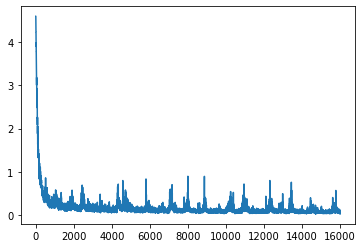

In [5]:
if __name__ == "__main__":
    train_loss, train_best  = main(seed, dim_input, dim_hidden)

In [7]:
# Test the performance
model_test = Net(dim_input, dim_hidden, nclass)
model_test.load_state_dict(torch.load( os.path.join(model_dir, 'model-' + savename + '.pt')))
model_test.float()
model_test.eval()
acc_list = scenario_test(scenario, w, rootPath, model_test)
print(acc_list)


testing_sigPQ_perturb_1
Test set results: loss= 0.0757 accuracy= 97.3214 1-hop accuracy = 0.9964
testing_sigPQ_perturb_1.5
Test set results: loss= 0.2822 accuracy= 90.5357 1-hop accuracy = 0.9875
testing_sigPQ_perturb_2
Test set results: loss= 0.6428 accuracy= 83.0357 1-hop accuracy = 0.9625
testing_sigPQ_perturb_3
Test set results: loss= 1.8313 accuracy= 69.1071 1-hop accuracy = 0.8625
[[97.32 90.54 83.04 69.11]]
